In [1]:
import pandas as pd
import numpy as np 

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdmolops
from collections import defaultdict
from rdkit.Chem import rdFMCS
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.MolStandardize import rdMolStandardize

#needed for show_mols
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG
from copy import deepcopy
import cairosvg
import math
import os
import glob

from rdkit import rdBase
rdBase.rdkitVersion

'2022.03.2'

In [2]:
#From https://www.rdkit.org/docs/Cookbook.html#neutralizing-molecules
def uncharge(mol):
    out_mol = deepcopy(mol)
    pattern = Chem.MolFromSmarts("[+1!h0!$([*]~[-1,-2,-3,-4]),-1!$([*]~[+1,+2,+3,+4])]")
    at_matches = out_mol.GetSubstructMatches(pattern)
    at_matches_list = [y[0] for y in at_matches]
    if len(at_matches_list) > 0:
        for at_idx in at_matches_list:
            atom = out_mol.GetAtomWithIdx(at_idx)
            chg = atom.GetFormalCharge()
            hcount = atom.GetTotalNumHs()
            atom.SetFormalCharge(0)
            atom.SetNumExplicitHs(hcount - chg)
            atom.UpdatePropertyCache()
    return out_mol

In [3]:
import itertools
def move_equivalent_hydrogens(mol):
    #1. Check if there exist both alkoxy and hydroxy group in molecular system
    total_charge = rdmolops.GetFormalCharge(mol)
    start_frags = Chem.GetMolFrags(mol, asMols=True)
    
    sub = Chem.MolFromSmarts('[O;H1;$(OC)].[O-;H0;$(OC)]')
    match = mol.GetSubstructMatches(sub)
    edited_mols = [mol]
    frag_lists = []
    if match:
        uncharged_mol = uncharge(mol)
        frags = Chem.GetMolFrags(uncharged_mol, asMols=True)
        #rxn1 = AllChem.ReactionFromSmarts('[O-;H0;$(OC):2]>>[O-0;H1:2]')
        rxn = AllChem.ReactionFromSmarts('[O;H1;$(OC):1]>>[O-;H0:1]')
        print(match, "found a match")
        #protonate alkoxy
        for frag in frags:
            products = rxn.RunReactants((frag,))        
            products = [products[i][0] for i in range(len(products))]
            if not products:
                producs = []
            for product in products:
                Chem.SanitizeMol(product)
            products.append(frag)
            frag_lists.append(products)
        mol_combinations = itertools.product(*frag_lists)
        edited_mols = []
        for mols in mol_combinations:
            charge = sum([rdmolops.GetFormalCharge(mols[i]) for i in range(len(frags))]) 
            if charge == total_charge:
                combined_mol = mols[0]
                for m in mols[1:]:
                    combined_mol = Chem.CombineMols(combined_mol, m)
                s = Chem.MolToSmiles(combined_mol)
                combined_mol = Chem.MolFromSmiles(s)
                edited_mols.append(combined_mol)
            
    edited_smiles = [Chem.MolToSmiles(mol) for mol in edited_mols]        

    return edited_smiles, edited_mols

In [4]:
def get_taus_and_protonation_mols(mol, solvent_reactions=False):
    """
    Generate tautomer/proton-transfer reactions for all found intermediates
    """
    if solvent_reactions:
        print("adding solvent")
        mol = Chem.CombineMols(mol, Chem.MolFromSmiles(solvent_reactions))
        Chem.SanitizeMol(mol)
    enumerator = rdMolStandardize.TautomerEnumerator()
    tauts = enumerator.Enumerate(mol)
    tauts_and_protonation_smiles = []
    for taut in tauts:
        smiles, edited_mols = move_equivalent_hydrogens(taut)
        if solvent_reactions:
            for s, m in zip(smiles, edited_mols):
                if solvent_reactions in s.split('.'):
                    m = rdmolops.DeleteSubstructs(m, Chem.MolFromSmiles(solvent_reactions), onlyFrags=True)
                    tauts_and_protonation_smiles.append(Chem.MolToSmiles(m))
                
        else:
            tauts_and_protonation_smiles += smiles
        

    unique_tauts_and_psmiles = set(tauts_and_protonation_smiles)
    unique_tauts_and_pmols = [Chem.MolFromSmiles(s) for s in unique_tauts_and_psmiles]
    return unique_tauts_and_psmiles, unique_tauts_and_pmols

In [5]:
def remove_protons(df):
    """
    removes reactions involving free protons in the product from dataframe
    """
    remove_rows = []
    for i, product in enumerate(df.Products_canonical):
        mols = product.split('.')
        if '[H+]' in mols:
            remove_rows.append(i)
    for i, product in enumerate(df.Reactants_canonical):
        mols = product.split('.')
        if '[H+]' in mols:
            remove_rows.append(i)
    print(remove_rows)
    df = df.sort_values(by="counts", ascending=False)
    df = df.drop(labels=remove_rows).reset_index(drop=True)
    
    return df

In [6]:
def remove_stereo_chemistry(df):
    """
    Gets SMILES with stereochemistry removed for evert canonical SMILES in the dataframe.
    Removed reactions where the only change between reactant and product is a change in stereochemistry
    """
    no_reaction = []
    for i in df.index:
        mp = Chem.MolFromSmiles(df.loc[i, "Products_canonical"])
        rdmolops.RemoveStereochemistry(mp)
        sp = Chem.MolToSmiles(mp)
        df.loc[i, 'p_nostereo'] = Chem.MolToSmiles(Chem.MolFromSmiles(sp))
        mr = Chem.MolFromSmiles(df.loc[i, "Reactants_canonical"])
        rdmolops.RemoveStereochemistry(mr)
        sr = Chem.MolToSmiles(mr)
        df.loc[i, 'r_nostereo'] = Chem.MolToSmiles(Chem.MolFromSmiles(sr))
        if sr == sp:
            no_reaction.append(i)
    print("removed {} reactions".format(len(no_reaction)))
    df = df.drop(labels=no_reaction).reset_index(drop=True)
        
    return df

In [7]:
def get_node_counts(node_smiles, df):
    """
    get list of important nodes evaluated based on 'counts'. For every reaction 'counts' is divided 
    between reactant and product. If the sum of 'counts' from reactions is greater than "count_cutoff",
    the node is added to the list of important nodes
    """
    node_counts = np.zeros(len(node_smiles))
    for count, rsmi, psmi in zip(df.counts, df.r_nostereo, df.p_nostereo):
        i = node_smiles.index(rsmi)
        j = node_smiles.index(psmi)
        node_counts[i] += count
        node_counts[j] += count
    return node_counts

In [8]:
_dir = os.getcwd()
all_files = glob.glob(os.path.join("", _dir+"/step1/*can.csv"))
li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=0, header=0)
    li.append(df)

reactions = pd.concat(li, axis=0, ignore_index=True)
reactions = reactions.groupby(["Products_canonical", "Reactants_canonical"])["counts"].sum().reset_index()
reactions = remove_protons(reactions)
reactions = remove_stereo_chemistry(reactions)

[0, 1, 2, 10, 17, 18, 22, 27, 35, 41, 60, 66, 68, 69, 125, 143, 144, 145, 147, 148, 149, 150, 151, 152]
removed 8 reactions


In [9]:
reactions = reactions.groupby(["p_nostereo", "r_nostereo"])["counts"].sum().reset_index()
reactions = reactions.sort_values(by="counts", ascending=False).reset_index(drop=True)
reactions = reactions[reactions.counts >= 2] 

In [10]:
#Each intermediate is gonna be represented by a node in the network
#A node represents all stereoisomers of a given system (stereoinformation removed from canonical SMILES)
_nodes = list(set(reactions.r_nostereo)|set(reactions.p_nostereo))
node_counts = get_node_counts(_nodes, reactions)

In [11]:
node_counts

array([  3.,  15.,  19.,   8.,   2.,   8.,   5.,   2.,  50.,  52.,   5.,
         2.,  40., 109.,   2.,   4.,   2.,   2.,  77., 100.,   5.,   3.,
        92.,   7.,  40.,   2.,  14.,   6.,  70.,   8.,   2.,   8.,  54.,
        89.,   8.,  31.,   9.,   2.,  85.,  76.,   7.,   4.,   8.,   6.,
         3.,   8.,   4., 109.,  19.,   2.,   3.,   2.,   7.,  38.,   2.,
        54.,  15.,   3.,   8.,  42.,  69.,  10.,   3.,  25.,  11.,  87.,
         3.,   2.])

In [12]:
node_and_counts = [(x, y) for y, x in sorted(zip(node_counts, _nodes), reverse=True)]
#nodes_dict = {node_and_counts[i][0]: np.arange(len(node_and_counts))[i] for i in range(len(node_and_counts))}
import csv
reader = csv.reader(open('nodes_dictionary.csv', 'r')) #dictionary containing SMILES to node integer mapping
nodes_dict = {}
for row in reader:
    k, v = row
    nodes_dict[k] = int(v)

In [13]:
nodes_dict

{'C=CC(O)=[O+]C.O': 0,
 'C=CC(=O)OC.[OH3+]': 1,
 'C=CC(=O)OC.[OH-]': 2,
 'C=C.C=CC(=O)OC': 3,
 'C=CC(=O)OC.S': 4,
 'C=CC(=O)OC.N': 5,
 'C=CC(=O)OC.C=O': 6,
 'C=CC(=O)OC.P': 7,
 'C=CC([O-])(O)OC': 8,
 'COC(=O)C1CCC1': 9,
 'COC(=O)C(C)S': 10,
 'C=CC(=O)OC.O=CO': 11,
 'COC(=O)C(C)P': 12,
 'COC([O-])=CC[NH3+]': 13,
 'COC([O-])=CCO': 14,
 'C=CC(O)(OC)OC=O': 15,
 'COC(O)=CCN': 16,
 'COCCCC=C=O': 17,
 'C=CC(O)(S)OC': 18,
 'COC(=O)C1CCO1': 19,
 'COC(=O)CCC=O': 20,
 'COC(=O)C(C)C=O': 21,
 'CC=C(OC)OS': 22,
 'COC1=CCCCO1': 23,
 'COC12OCCC1O2': 24,
 'COC([O-])=CC[PH3+]': 25,
 'COC(O)=CCOC=O': 26,
 'CC=C=O.COP': 27,
 'CC=C(OC)OP': 28,
 'C=[O+]C([O-])=CCCC': 29,
 'C=O.CCCC=C=O': 30,
 'C=CC(O)=[O+]C.[SH-]': 31,
 'C=CC(N)=O.CO': 32,
 'COC(O)=CCC=O': 33,
 'COC1CCOC1=O': 34,
 'COC(O)=CCS': 35,
 'CC1COCOC1=O': 36,
 'COC(=O)C1COC1': 37,
 'C=O.CC=C=O.N': 38,
 'C=CC(N)(O)OC': 39,
 'C=CC(=[OH+])OC.O=C[O-]': 40,
 'COCOCC=C=O': 41,
 'COC1=CCOCO1': 42,
 'COC1=CCCOO1': 43,
 'COC(=O)CCS': 44,
 'CO.NCC=C=O': 45,


In [14]:
reactions["r_nostereo_int"] = (reactions["r_nostereo"].apply(lambda x: nodes_dict.get(x)))
reactions["p_nostereo_int"] = (reactions["p_nostereo"].apply(lambda x: nodes_dict.get(x)))

In [15]:
#we define a node as important if it's involved in a reaction more than five times
important_smiles = [x for x,y in node_and_counts if y>5]
important_nodes = [nodes_dict[s] for s in important_smiles]
print((important_nodes))

[0, 1, 2, 3, 4, 74, 75, 5, 6, 7, 8, 9, 76, 77, 10, 11, 12, 78, 13, 14, 15, 16, 79, 17, 18, 19, 20, 21, 22, 23, 24, 80, 25, 26, 27, 28, 29, 30, 31, 32, 33, 81]


In [16]:
#Generate tautomer/proton-transfer reactions for the found meta-MD reactions
taut_edges = []
taut_smiles_list = []
for smiles in important_smiles:
    taut_smiles, taut_mols = get_taus_and_protonation_mols(Chem.MolFromSmiles(smiles), solvent_reactions=False)
    for taut_smiles in taut_smiles:
        taut_smiles_list.append(taut_smiles)
        if taut_smiles not in list(nodes_dict.keys()):
            print("new_node:", smiles)
            taut_idx = len(nodes_dict)
            nodes_dict[taut_smiles] = taut_idx
        if taut_smiles != smiles:
            taut_edges.append((nodes_dict[smiles], nodes_dict[taut_smiles], 100))
            taut_edges.append((nodes_dict[taut_smiles], nodes_dict[smiles], 100))
        if nodes_dict[taut_smiles] not in important_nodes:
            important_nodes.append(nodes_dict[taut_smiles])
            
            

((4, 3),) found a match
((6, 3),) found a match


In [17]:
edges_list = []
for i, j, count in zip(reactions.r_nostereo_int, reactions.p_nostereo_int, reactions.counts):
    edges_list.append((i,j, count))
print(edges_list)

[(1, 0, 109.0), (74, 75, 85.0), (2, 8, 69.0), (3, 9, 54.0), (76, 77, 52.0), (4, 10, 50.0), (7, 12, 40.0), (5, 13, 38.0), (2, 14, 31.0), (11, 15, 25.0), (78, 79, 19.0), (5, 16, 19.0), (3, 17, 15.0), (4, 18, 15.0), (6, 19, 14.0), (6, 20, 11.0), (6, 21, 10.0), (4, 22, 9.0), (7, 28, 8.0), (11, 26, 8.0), (7, 27, 8.0), (3, 29, 8.0), (3, 23, 8.0), (6, 24, 8.0), (78, 80, 8.0), (7, 25, 8.0), (5, 32, 7.0), (4, 31, 7.0), (3, 30, 7.0), (6, 33, 6.0), (78, 81, 6.0), (6, 36, 5.0), (6, 34, 5.0), (4, 35, 5.0), (5, 39, 4.0), (6, 37, 4.0), (5, 38, 4.0), (6, 41, 3.0), (11, 40, 3.0), (78, 82, 3.0), (5, 45, 3.0), (4, 44, 3.0), (6, 42, 3.0), (6, 43, 3.0), (76, 85, 2.0), (7, 47, 2.0), (6, 48, 2.0), (7, 46, 2.0), (7, 53, 2.0), (78, 86, 2.0), (74, 84, 2.0), (11, 54, 2.0), (78, 83, 2.0), (11, 49, 2.0), (5, 50, 2.0), (11, 51, 2.0), (6, 52, 2.0)]


In [43]:
#edges_df = pd.DataFrame()
#edges_df['idx_0'] = [edge_entry[0] for edge_entry in edges_list]
#edges_df['idx_1'] = [edge_entry[1] for edge_entry in edges_list]
#edges_df['edge_count'] = [edge_entry[2] for edge_entry in edges_list]
#edges_df.to_csv("meta-MD_edges_step1.csv")

In [44]:
#taut_edges_df = pd.DataFrame()
#taut_edges_df['idx_0'] = [edge_entry[0] for edge_entry in taut_edges]
#taut_edges_df['idx_1'] = [edge_entry[1] for edge_entry in taut_edges]
#taut_edges_df['edge_count'] = [edge_entry[2] for edge_entry in taut_edges]
#taut_edges_df.to_csv("taut_edges_step1.csv")

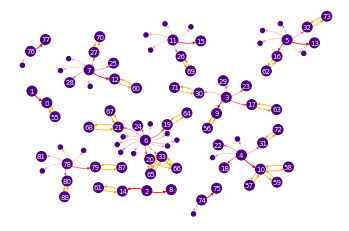

In [19]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

seed = 13648  # Seed random number generators for reproducibility
G = nx.MultiDiGraph()
for x, y, z in edges_list:
    G.add_edge(x,y, color='red', alpha=(min(30,z)+5)/35)
for x, y, z in taut_edges:
    G.add_edge(x,y, color='orange', alpha=0.9)
    
edge_colors = nx.get_edge_attributes(G,'color').values()
edge_alphas = nx.get_edge_attributes(G,'alpha').values()
pos = nx.nx_agraph.graphviz_layout(G)

node_sizes = [20 for i in range(len(G))]
for k, i in enumerate(list(G.nodes)):
    if i in important_nodes:
        node_sizes[k]=100
       
cmap = plt.cm.Purples



nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="indigo", margins=0)
edges = nx.draw_networkx_edges(
    G,
    pos,
    node_size=node_sizes,
    arrows="FancyArrowPatch",
    arrowstyle="-|>",
    arrowsize=5,
    connectionstyle="arc3, rad=0.2",
    edge_color=edge_colors,
    alpha = list(edge_alphas),
    #edge_cmap=cmap,
    width=0.8,
    #edge_vmin=0,
    
)

pos_important = {k: pos[k] for k in important_nodes}
labels_important = {n: n for n in important_nodes}
labels = nx.draw_networkx_labels(G, pos_important, labels=labels_important, font_color="whitesmoke", font_size=7)


pc = mpl.collections.PatchCollection(edges, cmap=cmap)
#pc.set_array(edge_colors)

ax = plt.gca()
ax.set_axis_off()
#plt.savefig("template_graphs.pdf")
plt.show()

In [22]:
#11 seperated networks, one for each possible catalyst template tested
subgraphs = [G.subgraph(c).copy() for c in nx.connected_components(G.to_undirected())]
len(subgraphs)

11

The code below extracts a subgraph from the total network (for all possible catalyst templates)
Only intermediates labelled important and with low enough reaction free energies are shown.

In [20]:
def draw_subgraph(subG, energy_dictionary, filename=None, font_size=None, node_size=150, arrow_size=7, arrow_width=1):
    remove_list = []
    for node in subG.nodes:
        try:
            if node not in important_nodes or energy_dictionary[node] > 30 or np.isnan(energy_dictionary[node]):
                remove_list.append(node)
        except KeyError:
            print("labelled important: ", node)
            remove_list.append(node)
            
            
    print("removed = ", remove_list)
    

    subG.remove_nodes_from(remove_list)
    solitary=[n for n,d in subG.degree() if d==0]
    subG.remove_nodes_from(solitary)
    print("total nodes = ", len(subG.nodes))
    pos = nx.nx_agraph.graphviz_layout(subG)
    if 456 in subG.nodes:
        print("HERE!")
    print("nodes = ", subG.nodes)
    node_sizes = [20 for i in range(len(subG))]
    for k, i in enumerate(list(subG.nodes)):
        if i in important_nodes:
            node_sizes[k]=node_size

    edge_colors = nx.get_edge_attributes(subG,'color').values()
    edge_alphas = nx.get_edge_attributes(subG,'alpha').values()
    
    nodes = nx.draw_networkx_nodes(subG, pos, node_size=node_sizes, node_color="indigo", margins=0)
    edges = nx.draw_networkx_edges(
        subG,
        pos,
        node_size=node_sizes,
        arrows="FancyArrowPatch",
        arrowstyle="-|>",
        arrowsize=arrow_size,
        connectionstyle="arc3, rad=0.2",
        edge_color=edge_colors,
        alpha = list(edge_alphas),
        width=arrow_width 
    )

    pos_important = {}
    labels_important = {}
    for node in list(subG.nodes):
        if node in important_nodes:
            pos_important[node] = pos[node]
            labels_important[node] = node

    
    if font_size:
        labels = nx.draw_networkx_labels(subG, pos_important, labels=labels_important, font_color="whitesmoke", font_size=font_size)


    pc = mpl.collections.PatchCollection(edges, cmap=cmap)

    ax = plt.gca()
    ax.set_axis_off()
    if filename:
        plt.savefig(filename)
    plt.show()
    
    return list(subG.nodes)

In [23]:
reader = csv.reader(open('node_energies_step1+2+3.csv', 'r'))
energy_dict = {}
for row in reader:
    k, v = row
    energy_dict[int(k)] = float(v)

removed =  []
total nodes =  4
nodes =  [69, 11, 15, 26]


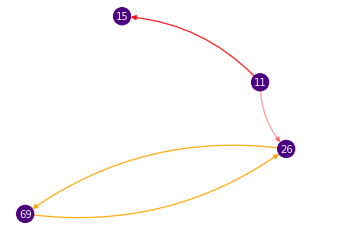

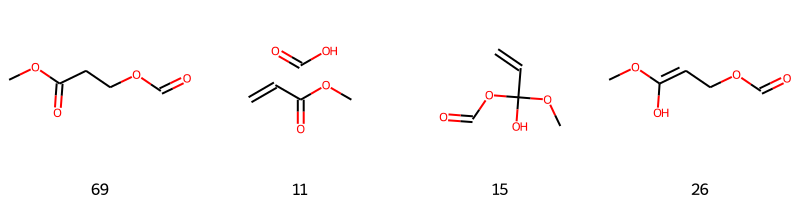

In [29]:
temp_nodes = draw_subgraph(subgraphs[8], energy_dict, filename = None, node_size=300, font_size=10, arrow_size=10, arrow_width=1.3)
temp_smiles = [list(nodes_dict.keys())[list(nodes_dict.values()).index(i)] for i in temp_nodes]
temp_mols = [Chem.MolFromSmiles(s) for s in temp_smiles]
img = Draw.MolsToGridImage(temp_mols, molsPerRow=4, useSVG=True, legends = [str(i) for i in temp_nodes], maxMols=400)
img